In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
from scipy.fft import fft, ifft, fftfreq
from scipy.signal import lti, lsim, bode
import matplotlib.pyplot as plt
from scipy.optimize import fsolve, minimize

# Load data
file_name = 'May03 clean IABC data.xlsx'  # Upload heartbeat waveform to runtime and paste path here.
sampling_rate = 250  # Replace with your actual sampling rate in Hz

# Load data from Excel
data = pd.read_excel(file_name)
time = data['Time'].values
waveform = data['Waveform'].values

# Ensure the time and waveform arrays are numpy arrays
time = np.array(time)
waveform = np.array(waveform)

## User defined input
Change the maximum allowable error

In [ ]:
max_error_threshold = 8  # User-defined threshold for maximum error
error_cap = 15  # For plotting purposes. Prevents contour plot from "blowing out" due to high errors at low natural frequencies.

## Code and output plot

In [ ]:
# Define parameters
num_steps = 30
natural_frequencies = np.linspace(0.05, 30, num_steps)
damping_ratios = np.linspace(0.05, 2, num_steps)

# Placeholder for storing maximum errors
error_table = np.zeros((num_steps, num_steps))

# Iterate through all combinations of natural frequencies and damping ratios
for i, natural_frequency in enumerate(natural_frequencies):
    for j, damping_ratio in enumerate(damping_ratios):
        omega_n = 2 * np.pi * natural_frequency  # Convert to rad/s from Hz
        if omega_n == 0:  # Skip zero frequency to avoid division by zero
            error_table[j, i] = np.inf
            continue

        # Define the second order system
        numerator = [omega_n**2]
        denominator = [1, 2*damping_ratio*omega_n, omega_n**2]
        system = lti(numerator, denominator)

        # Simulate the system response
        t_out, y_out, x_out = lsim(system, U=waveform, T=time)

        # Calculate the errors
        start_index = 100  # Adjust the start index as needed
        errors = np.abs(y_out[start_index:] - waveform[start_index:])
        max_error = np.max(errors)

        # Save the maximum error in the table, capping at 15 mmHg
        error_table[j, i] = min(max_error, error_cap)

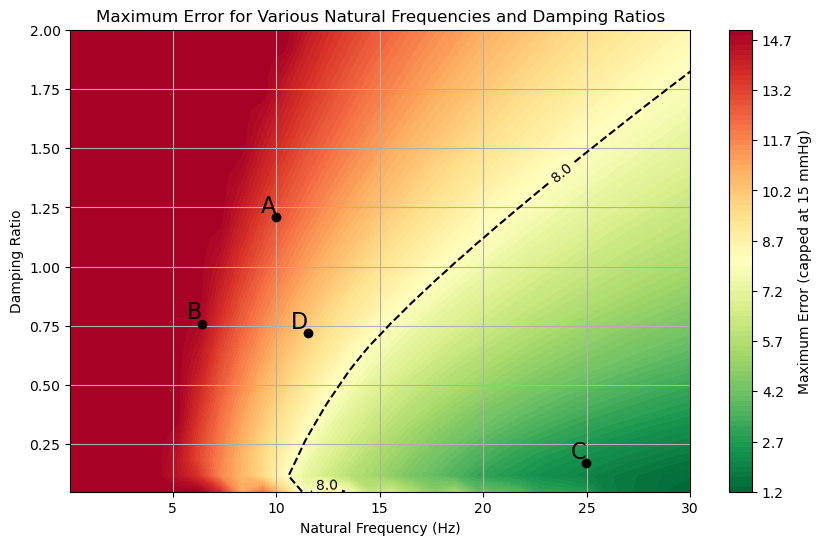

In [ ]:
# Create a plot of the results
plt.figure(figsize=(10, 6))
contour = plt.contourf(natural_frequencies, damping_ratios, error_table, levels=100, cmap='RdYlGn_r')
plt.colorbar(contour, label=f'Maximum Error (capped at {error_cap} mmHg)')
contour = plt.contour(natural_frequencies, damping_ratios, error_table, levels=[max_error_threshold], colors='black', linestyles='--')
plt.clabel(contour, fmt='%1.1f', colors='black', fontsize=10)

plt.plot(9.97,1.21, marker='o', label='A', color='black')
plt.text(9.97,1.21, 'A', verticalalignment='bottom', horizontalalignment='right',fontsize=16)  # Add the label
plt.plot(6.41,0.76, marker='o', label='B', color='black')
plt.text(6.41,0.76, 'B', verticalalignment='bottom', horizontalalignment='right',fontsize=16)  # Add the label
plt.plot(24.98,0.17, marker='o', label='C', color='black')
plt.text(24.98,0.17, 'C', verticalalignment='bottom', horizontalalignment='right',fontsize=16)  # Add the label
plt.plot(11.55,0.72, marker='o', label='D', color='black')
plt.text(11.55,0.72, 'D', verticalalignment='bottom', horizontalalignment='right',fontsize=16)  # Add the label

plt.xlabel('Natural Frequency (Hz)')
plt.ylabel('Damping Ratio')
plt.title('Maximum Error for Various Natural Frequencies and Damping Ratios')
plt.grid(True)
plt.show()